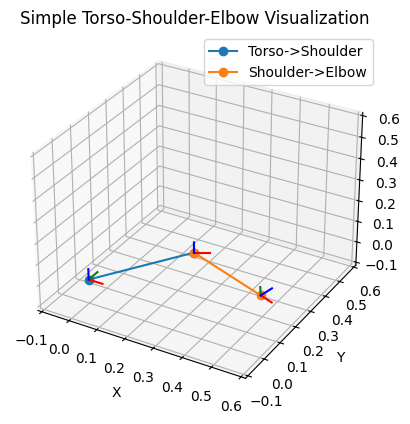

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# ---------- Simple Transform Utilities ----------
def rotation_z(theta):
    """Return a 4x4 homogeneous rotation matrix about the Z-axis."""
    c = np.cos(theta)
    s = np.sin(theta)
    return np.array([
        [c, -s, 0, 0],
        [s,  c, 0, 0],
        [0,  0, 1, 0],
        [0,  0, 0, 1]
    ])

def translation(tx, ty, tz):
    """Return a 4x4 homogeneous translation matrix."""
    T = np.eye(4)
    T[0, 3] = tx
    T[1, 3] = ty
    T[2, 3] = tz
    return T

def apply_transform(T, point3):
    """
    Apply a 4x4 homogeneous transform T to a 3D point (x, y, z).
    Returns the transformed 3D coordinates (x', y', z').
    """
    # Convert (x,y,z) -> homogeneous coords (x,y,z,1)
    homo_point = np.array([point3[0], point3[1], point3[2], 1.0])
    transformed = T @ homo_point
    return transformed[:3]

def draw_axes(ax, T, axis_length=0.05):
    """
    Draw small coordinate axes (red=X, green=Y, blue=Z) at the origin 
    defined by transform T.
    """
    origin = apply_transform(T, [0, 0, 0])
    x_axis = apply_transform(T, [axis_length, 0, 0])
    y_axis = apply_transform(T, [0, axis_length, 0])
    z_axis = apply_transform(T, [0, 0, axis_length])

    # X-axis (red)
    ax.plot(
        [origin[0], x_axis[0]],
        [origin[1], x_axis[1]],
        [origin[2], x_axis[2]],
        color='red'
    )
    # Y-axis (green)
    ax.plot(
        [origin[0], y_axis[0]],
        [origin[1], y_axis[1]],
        [origin[2], y_axis[2]],
        color='green'
    )
    # Z-axis (blue)
    ax.plot(
        [origin[0], z_axis[0]],
        [origin[1], z_axis[1]],
        [origin[2], z_axis[2]],
        color='blue'
    )

# ---------- Define the Rigid Bodies (Torso -> Shoulder -> Elbow) ----------
# Torso frame as the global frame (Identity)
T_torso_global = np.eye(4)

# Shoulder offset from the torso
T_shoulder_offset = translation(0.2, 0.3, 0.0)

# Shoulder joint rotation (say 30 deg around Z)
shoulder_angle = np.radians(30)
R_shoulder = rotation_z(shoulder_angle)

# Combine: Torso -> Shoulder
T_torso_to_shoulder = T_shoulder_offset @ R_shoulder

# Upper arm length (0.3 m), from Shoulder to Elbow
T_arm_length = translation(0.3, 0, 0)

# Suppose we have an extra rotation at the shoulder (e.g., flexion 45 deg around Y)
R_shoulder_flex = np.array([
    [ np.cos(np.radians(45)), 0, np.sin(np.radians(45)), 0],
    [ 0, 1, 0, 0],
    [-np.sin(np.radians(45)), 0, np.cos(np.radians(45)), 0],
    [ 0, 0, 0, 1]
])

# Combine: Torso -> Shoulder -> (Extra rotation) -> Elbow
T_torso_to_elbow = T_torso_to_shoulder @ R_shoulder_flex @ T_arm_length

# ---------- Get the Points in Global Coordinates ----------
torso_origin   = apply_transform(T_torso_global, [0, 0, 0])
shoulder_point = apply_transform(T_torso_to_shoulder, [0, 0, 0])
elbow_point    = apply_transform(T_torso_to_elbow, [0, 0, 0])

# ---------- Plot in 3D ----------
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot lines representing segments: Torso->Shoulder and Shoulder->Elbow
ax.plot(
    [torso_origin[0], shoulder_point[0]],
    [torso_origin[1], shoulder_point[1]],
    [torso_origin[2], shoulder_point[2]],
    'o-', label='Torso->Shoulder'
)
ax.plot(
    [shoulder_point[0], elbow_point[0]],
    [shoulder_point[1], elbow_point[1]],
    [shoulder_point[2], elbow_point[2]],
    'o-', label='Shoulder->Elbow'
)

# Draw small coordinate axes at each point
draw_axes(ax, T_torso_global, axis_length=0.05)
draw_axes(ax, T_torso_to_shoulder, axis_length=0.05)
draw_axes(ax, T_torso_to_elbow, axis_length=0.05)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simple Torso-Shoulder-Elbow Visualization')
ax.legend()

# Adjust the view limits for better visibility
ax.set_xlim([-0.1, 0.6])
ax.set_ylim([-0.1, 0.6])
ax.set_zlim([-0.1, 0.6])

plt.show()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

%matplotlib notebook

# Utility Functions
def rotation_z(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s, 0, 0], [s, c, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

def rotation_y(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, 0, s, 0], [0, 1, 0, 0], [-s, 0, c, 0], [0, 0, 0, 1]])

def translation(tx, ty, tz):
    T = np.eye(4)
    T[:3, 3] = [tx, ty, tz]
    return T

def apply_transform(T, point3):
    homo_point = np.append(point3, 1.0)  # Homogeneous coordinates
    return (T @ homo_point)[:3]  # Transform and return 3D coordinates

# Model Parameters
T_torso_global = np.eye(4)
T_shoulder_offset = translation(0.2, 0.3, 0.0)
T_arm_length = translation(0.3, 0, 0)

def get_elbow_transform(shoulder_z_angle_deg, shoulder_y_angle_deg):
    theta_z, theta_y = np.radians(shoulder_z_angle_deg), np.radians(shoulder_y_angle_deg)
    T_torso_to_shoulder = T_shoulder_offset @ rotation_z(theta_z)
    T_torso_to_elbow = T_torso_to_shoulder @ rotation_y(theta_y) @ T_arm_length
    return T_torso_to_elbow

# Animation Setup
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
line, = ax.plot([], [], [], 'o-', lw=2)

ax.set_xlim([-0.1, 0.6])
ax.set_ylim([-0.1, 0.6])
ax.set_zlim([-0.1, 0.6])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simple Torso-Shoulder-Elbow Animation')

def init():
    line.set_data([], [])
    line.set_3d_properties([])
    return line,

def update(frame):
    shoulder_z_angle = frame
    shoulder_y_angle = 45 + 20 * np.sin(np.radians(frame))
    T_elbow = get_elbow_transform(shoulder_z_angle, shoulder_y_angle)
    
    torso_origin = apply_transform(T_torso_global, [0, 0, 0])
    shoulder_origin = apply_transform(T_shoulder_offset @ rotation_z(np.radians(shoulder_z_angle)), [0, 0, 0])
    elbow_origin = apply_transform(T_elbow, [0, 0, 0])
    
    xs = [torso_origin[0], shoulder_origin[0], elbow_origin[0]]
    ys = [torso_origin[1], shoulder_origin[1], elbow_origin[1]]
    zs = [torso_origin[2], shoulder_origin[2], elbow_origin[2]]
    
    line.set_data(xs, ys)
    line.set_3d_properties(zs)
    return line,

frames = np.arange(0, 91, 2)
anim = FuncAnimation(fig, update, frames=frames, init_func=init, blit=False, interval=100)

# Display Animation in Jupyter Notebook
HTML(anim.to_html5_video())

# Utility Functions
def rotation_z(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, -s, 0, 0], [s, c, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]])

def rotation_y(theta):
    c, s = np.cos(theta), np.sin(theta)
    return np.array([[c, 0, s, 0], [0, 1, 0, 0], [-s, 0, c, 0], [0, 0, 0, 1]])

def translation(tx, ty, tz):
    T = np.eye(4)
    T[:3, 3] = [tx, ty, tz]
    return T

def apply_transform(T, point3):
    homo_point = np.append(point3, 1.0)  # Homogeneous coordinates
    return (T @ homo_point)[:3]  # Transform and return 3D coordinates

# Model Parameters
T_torso_global = np.eye(4)
T_shoulder_offset = translation(0.2, 0.3, 0.0)
T_arm_length = translation(0.3, 0, 0)

def get_elbow_transform(shoulder_z_angle_deg, shoulder_y_angle_deg):
    theta_z, theta_y = np.radians(shoulder_z_angle_deg), np.radians(shoulder_y_angle_deg)
    T_torso_to_shoulder = T_shoulder_offset @ rotation_z(theta_z)
    T_torso_to_elbow = T_torso_to_shoulder @ rotation_y(theta_y) @ T_arm_length
    return T_torso_to_elbow

# Animation Setup
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
line, = ax.plot([], [], [], 'o-', lw=2)

ax.set_xlim([-0.1, 0.6])
ax.set_ylim([-0.1, 0.6])
ax.set_zlim([-0.1, 0.6])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Simple Torso-Shoulder-Elbow Animation')

def init():
    line.set_data([], [])
    line.set_3d_properties([])
    return line,

def update(frame):
    shoulder_z_angle = frame
    shoulder_y_angle = 45 + 20 * np.sin(np.radians(frame))
    T_elbow = get_elbow_transform(shoulder_z_angle, shoulder_y_angle)
    
    torso_origin = apply_transform(T_torso_global, [0, 0, 0])
    shoulder_origin = apply_transform(T_shoulder_offset @ rotation_z(np.radians(shoulder_z_angle)), [0, 0, 0])
    elbow_origin = apply_transform(T_elbow, [0, 0, 0])
    
    xs = [torso_origin[0], shoulder_origin[0], elbow_origin[0]]
    ys = [torso_origin[1], shoulder_origin[1], elbow_origin[1]]
    zs = [torso_origin[2], shoulder_origin[2], elbow_origin[2]]
    
    line.set_data(xs, ys)
    line.set_3d_properties(zs)
    return line,

frames = np.arange(0, 91, 2)
anim = FuncAnimation(fig, update, frames=frames, init_func=init, blit=False, interval=100)

# Display Animation in Jupyter Notebook
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>